<a href="https://www.kaggle.com/code/cmosbattery/mammal-classification-with-cnn-and-regularization?scriptVersionId=219009122" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Mammal Classification with CNN and Regularization

In this Notebook, we will develop a Convolutional Neural Network (CNN) model that trains on an image dataset of mammals belonging to 45 classes. The dataset used came from the Mammals Image Classification Dataset (45 Animals). We will also apply model regularization techniques to address overfitting and improve the generalization of the model.

## 1. Setup

In this section, we set up the environment and import the necessary libraries for building the CNN model, as well as for visualizing the data and handling the dataset. We will use TensorFlow for the CNN model and Matplotlib for data visualization.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import PIL
import os
import random
import shutil
import zipfile
from collections import defaultdict

## 2. Data Preprocessing

In this section, we preprocess the dataset to ensure that the images are ready for model training. This includes organizing the data, balancing the number of sample images across all classes, applying necessary transformations such as resizing, and splitting the dataset into training and validation sets for optimal model evaluation.

In [2]:
data_directory = Path("/kaggle/input/mammals-image-classification-dataset-45-animals/mammals")
image_count = len(list(data_directory.rglob('*.*')))
print(f"The number of images present in the dataset: {image_count}")

The number of images present in the dataset: 13751


<function matplotlib.pyplot.show(close=None, block=None)>

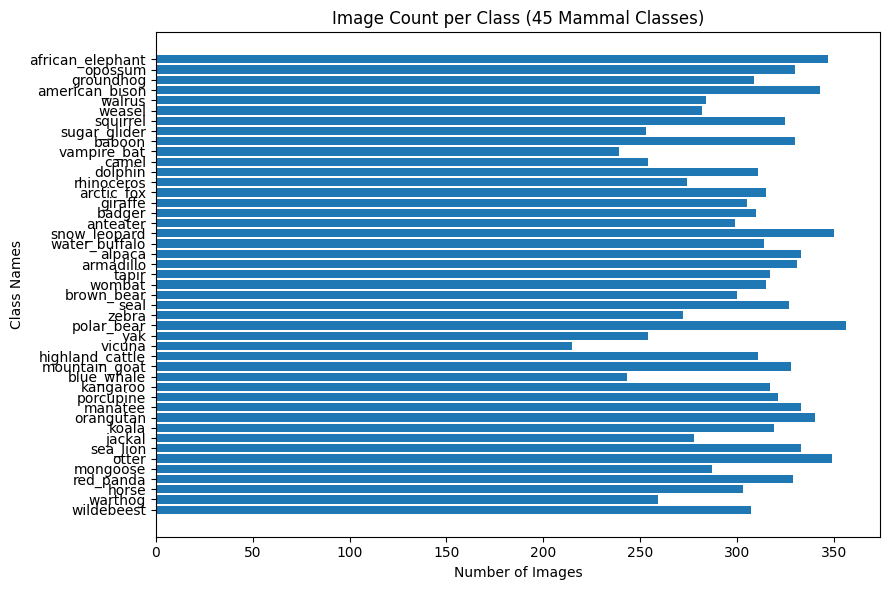

In [3]:
# Dictionary to store the count of images per class
image_count_per_class = defaultdict(int)

# Iterate through each class directory
for class_dir in data_directory.iterdir():
    if class_dir.is_dir():  # Check if it's a directory
        class_name = class_dir.name
        image_count_per_class[class_name] = len(list(class_dir.glob('*.jpg')))

# Prepare data for plotting
class_names = list(image_count_per_class.keys())
image_counts = list(image_count_per_class.values())

plt.figure(figsize=(9, 6))
plt.barh(class_names, image_counts)
plt.title(f"Image Count per Class ({len(image_count_per_class)} Mammal Classes)")
plt.xlabel("Number of Images")
plt.ylabel("Class Names")
plt.tight_layout()
plt.show

Some of the classes have greater amount of images than others, this creates data imbalance and could potentially cause bias during the training process. This results for them have better representation during the training than those who have few images. With that, we will only limit them to only having 200 images per class.

Total images collected: 9000


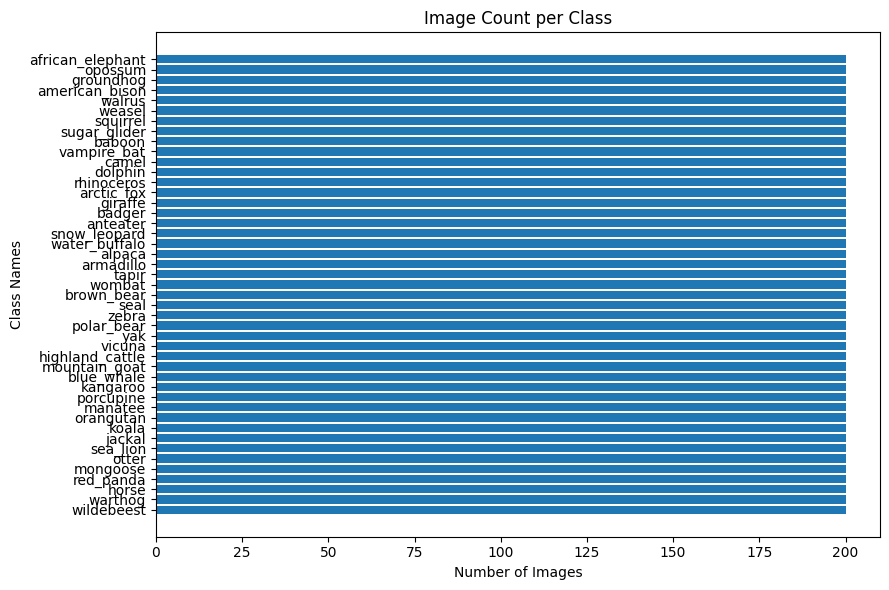

In [4]:
REQ_IMAGE_COUNT = 200

# Create a list to store the filtered images
filtered_images = []

# Dictionary to store the new count of images per class after filtering
filtered_image_count_per_class = defaultdict(int)

# Iterate through each class directory
class_directories = [d for d in data_directory.iterdir() if d.is_dir()]

for class_dir in class_directories:
    images = list(class_dir.glob('*.jpg'))
    
    # If more than 200 images are present, randomly select 200
    if len(images) > REQ_IMAGE_COUNT:
        images = random.sample(images, REQ_IMAGE_COUNT)

    class_name = class_dir.name
    filtered_image_count_per_class[class_name] = len(images)
    
    # Add the selected images to the filtered list
    filtered_images.extend(images)

# Prepare data for plotting
class_names = list(filtered_image_count_per_class.keys())
image_counts = list(filtered_image_count_per_class.values())

plt.figure(figsize=(9, 6))
plt.barh(class_names, image_counts)
plt.title(f"Image Count per Class")
plt.xlabel("Number of Images")
plt.ylabel("Class Names")
plt.tight_layout()
plt.show


# Check the total number of images collected
print(f"Total images collected: {len(filtered_images)}")

We will be storing these filtered classes into a new directory.

> directory: /kaggle/working/filtered_mammals 

In [5]:
# Create a new directory to store the filtered dataset
filtered_data_directory = Path("/kaggle/working/filtered_mammals")

# Create subdirectories for each class
for class_dir in class_directories:
    class_name = class_dir.name
    (filtered_data_directory / class_name).mkdir(parents=True, exist_ok=True)

# Copy filtered images to the new directory
for image_path in filtered_images:
    class_name = image_path.parent.name
    destination = filtered_data_directory / class_name / image_path.name
    shutil.copy(image_path, destination)

We split the dataset for training, which accounts to 80% of the whole dataset, and 20% for validation.

In [6]:
IMAGE_BATCH = 32
IMAGE_SIZE = (150, 150)
VAL_SPLIT = 0.2

train_dataset = tf.keras.utils.image_dataset_from_directory(
    filtered_data_directory,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=123,
    image_size=(IMAGE_SIZE),
    batch_size=IMAGE_BATCH,
    label_mode='int'
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    filtered_data_directory,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=123,
    image_size=(IMAGE_SIZE),
    batch_size=IMAGE_BATCH,
    label_mode='int'
)

Found 9000 files belonging to 45 classes.
Using 7200 files for training.
Found 9000 files belonging to 45 classes.
Using 1800 files for validation.


We will do a final check on the number of classes present in the training dataset below which is indeed 45 classes.

In [7]:
class_names = train_dataset.class_names
print('Number of classes:', len(class_names), "\n", class_names)

Number of classes: 45 
 ['african_elephant', 'alpaca', 'american_bison', 'anteater', 'arctic_fox', 'armadillo', 'baboon', 'badger', 'blue_whale', 'brown_bear', 'camel', 'dolphin', 'giraffe', 'groundhog', 'highland_cattle', 'horse', 'jackal', 'kangaroo', 'koala', 'manatee', 'mongoose', 'mountain_goat', 'opossum', 'orangutan', 'otter', 'polar_bear', 'porcupine', 'red_panda', 'rhinoceros', 'sea_lion', 'seal', 'snow_leopard', 'squirrel', 'sugar_glider', 'tapir', 'vampire_bat', 'vicuna', 'walrus', 'warthog', 'water_buffalo', 'weasel', 'wildebeest', 'wombat', 'yak', 'zebra']


We will visually check the images contained in the classes of the training dataset.

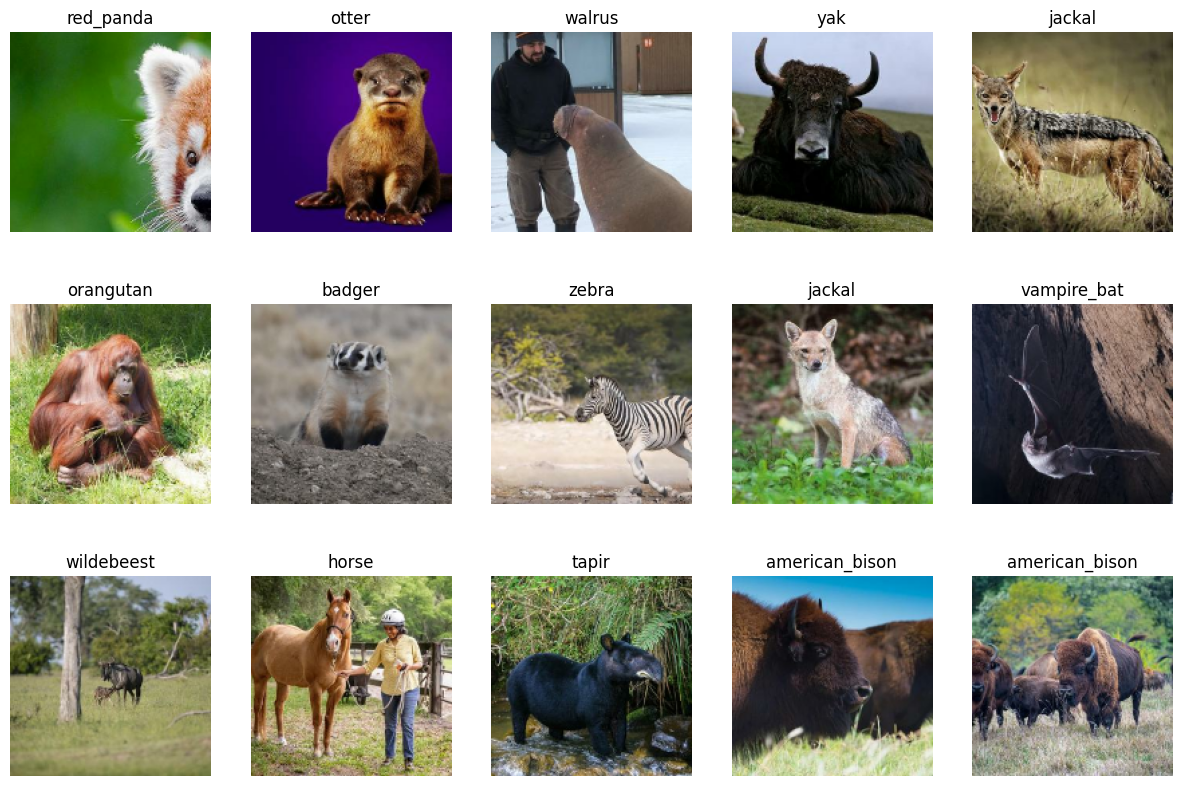

In [8]:
plt.figure(figsize=(15, 10))
for images, labels in train_dataset.take(1):
  for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Prefetching is done in order to optimize data loading and improve the training time efficiency.

## 3. Building and Training the Baseline Model

For the initial baseline model, we will train the CNN with a standard configuration of three convolutional layers. The model will run for 20 epochs to observe how well the baseline performs with simple architecture. The model will be validated on the separate validation subdataset to assess its performance and observe any overfitting. 

In [10]:
num_classes = len(class_names)

model = Sequential([
    layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    layers.Rescaling(1./255),

    # First layer with 16 filters
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    # Second layer with 32 filters
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Third layer with 64 filters
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,654,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 45)                  │           5,805 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,683,725 (10.24 MB)

 Trainable params: 2,683,725 (10.24 MB)

 Non-trainable params: 0 (0.00 B)

Before training the model, we compile it with the Adam optimizer, which adapts the learning rate for efficient training. The Sparse Categorical Crossentropy loss function is used since the task is a multi-class classification problem with integer labels. The model will also track accuracy as a performance metric during training

In [11]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [12]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20
)

Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.0535 - loss: 3.7124 - val_accuracy: 0.1639 - val_loss: 3.1954
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1820 - loss: 3.0784 - val_accuracy: 0.2183 - val_loss: 2.9237
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2761 - loss: 2.6932 - val_accuracy: 0.2300 - val_loss: 2.9056
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3881 - loss: 2.2370 - val_accuracy: 0.2756 - val_loss: 2.7907
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5464 - loss: 1.6510 - val_accuracy: 0.2706 - val_loss: 3.1514
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7280 - loss: 1.0018 - val_accuracy: 0.2656 - val_loss: 3.5479
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8579 - loss: 0.5377 - val_accuracy: 0.2506 - val_loss: 4.4495
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9362 - loss: 0.2640 - val_accuracy: 

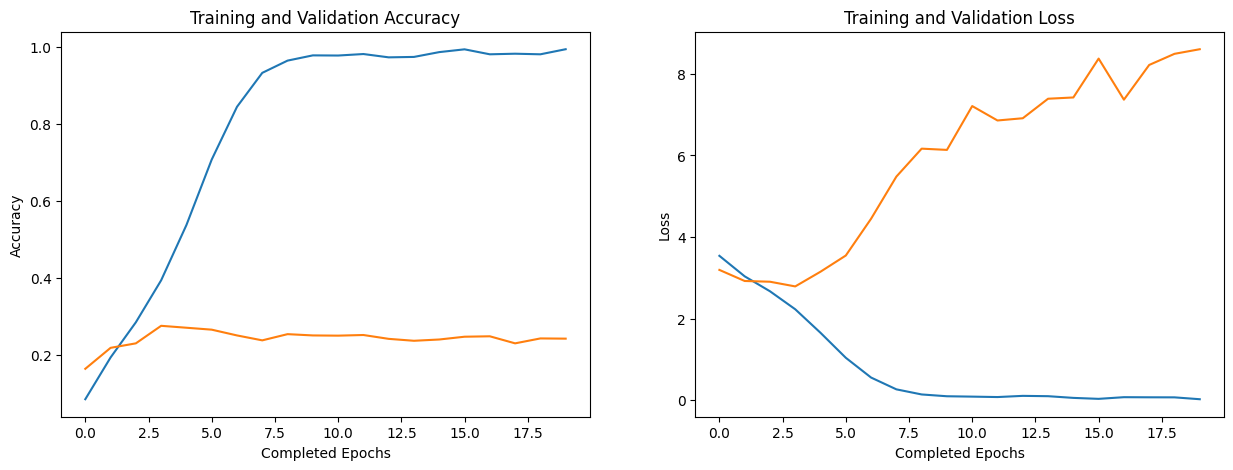

In [13]:
# Function to visualize the training and validation logs from model's history
def vis_logs(model):
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']
    
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel("Completed Epochs")
    plt.ylabel("Accuracy")
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel("Completed Epochs")
    plt.ylabel("Loss")
    plt.show()

vis_logs(history)

After training for 20 epochs, we observe significant gaps between the accuracy and loss in both plots. This is a clear indication of **overfitting** wherein the model performs too well in the training data, however in the validation, it is not performing well on the unforseen data. 

To address this issue of overfitting of our baseline model, we plan to implement the following techniques:

- **Data Augmentation**: Use data augmentation to artificially increase the size of the training set, providing the model with more varied examples to learn from.
- **Dropout**: Introduce dropout layers to randomly deactivate neurons during training, forcing the model to learn more robust features.
- **L2 Regularization**: Apply L2 regularization to penalize large weights and encourage the model to generalize better.

Additionally, we will implement the early stopping mechanism to halt training when the validation loss stops improving and adjust the learning rate if the validation performance plateaus during training.

## 4. Data Augmentation

The training images will be randomly augmented both horizontally and vertically with random rotation and zooming. This allows the model in trainig session to learn all the possible features even if the images are rotated or zoomed. This augmentation approach will be configured as a layer to the model.

In [14]:
data_augmentation = keras.Sequential([
    layers.RandomFlip(mode="horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

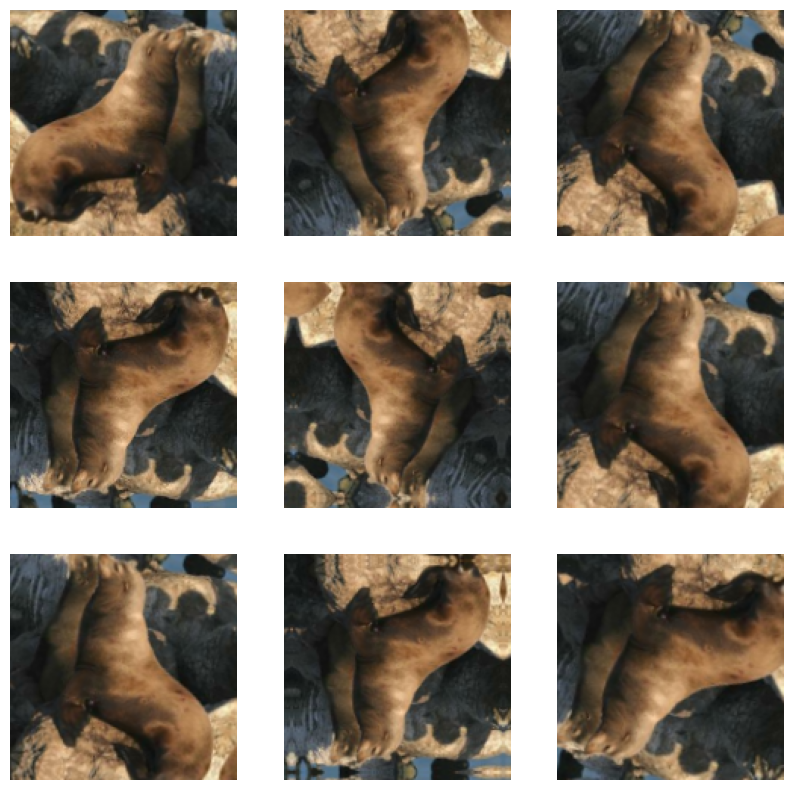

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

After we define the data augmentation layer, we will insert it in between the input (layers.Input) layer and the normalization (layers.Rescaling) layer.

In [16]:
num_classes = len(class_names)

model_2 = Sequential([
    layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    data_augmentation, 
    layers.Rescaling(1./255),

    # First layer with 16 filters
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    # Second layer with 32 filters
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Third layer with 64 filters
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       2,654,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 45)                  │           5,805 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,683,725 (10.24 MB)

 Trainable params: 2,683,725 (10.24 MB)

 Non-trainable params: 0 (0.00 B)



For this training, we will train the model for 20 epochs and set the early stopping mechanism with a patience of **5 epochs**, which will stop training if the validation loss does not improve for **5 consecutive epochs**. Additionally, we will adjust the learning rate by reducing it by **50%** if the validation loss plateaus, with a patience of **3 epochs** and a minimum learning rate of **1e-6**.

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_2.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3, 
    min_lr=1e-6
)

history_2 = model_2.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=20,
  callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.0356 - loss: 3.7865 - val_accuracy: 0.0700 - val_loss: 3.5875 - learning_rate: 1.0000e-04
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.0738 - loss: 3.5823 - val_accuracy: 0.0956 - val_loss: 3.4797 - learning_rate: 1.0000e-04
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.1154 - loss: 3.4107 - val_accuracy: 0.1311 - val_loss: 3.4030 - learning_rate: 1.0000e-04
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.1315 - loss: 3.3183 - val_accuracy: 0.1317 - val_loss: 3.3375 - learning_rate: 1.0000e-04
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.1509 - loss: 3.2023 - val_accuracy: 0.1472 - val_loss: 3.2549 - learning_rate: 1.0000e-04
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.1658 - loss: 3.1492 - val_accuracy: 0.1728 - val_loss: 3.2051 - learning_rate: 1.0000e-04
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - acc

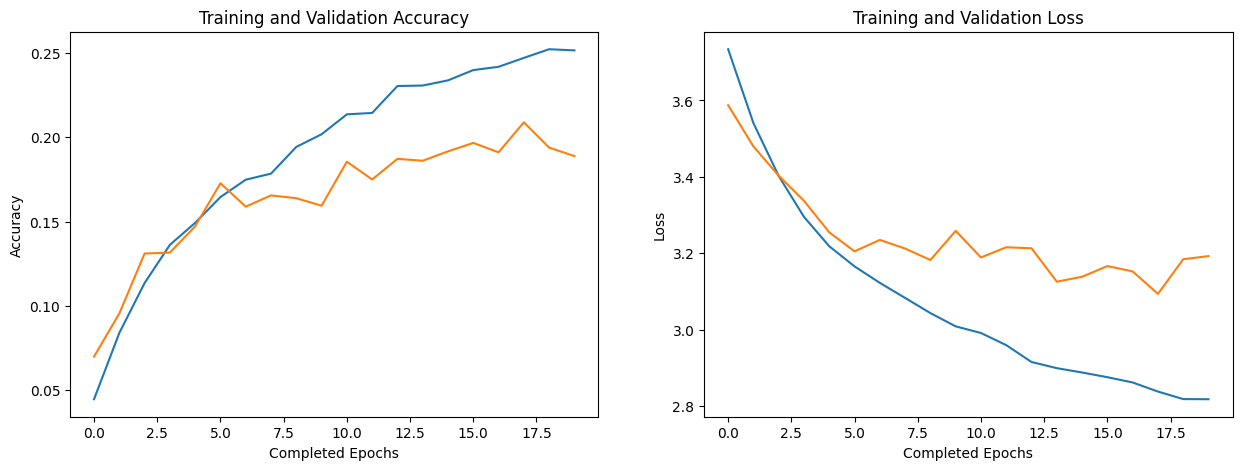

In [18]:
vis_logs(history_2)

After training the model with data augmentation for **20 epochs**, we observe that both the training and validation accuracy and loss improved over time, showing some reduction in overfitting. As the training process reached the end of the epoch, the learning rate further decreased to **5x10^-5**, indicating that at the later stages of the training a degradation in validation performance is being observed.

Moving forward, to further address the overfitting issue, we will apply regularization techniques, such as dropout, with the goal of enhancing the model's performance on the validation data. We will also increasing the minimum number of filters to **32** from the initial value of **16**.

## 5. Model Regularization: Dropout

We will add a **Dropout layer** with a rate of **10%** after the **Dense layer** to help model reduce the overfitting by randomly deactivating the neurons during the training process.

In [19]:
num_classes = len(class_names)

model_3 = Sequential([
    layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    data_augmentation, 
    layers.Rescaling(1./255),

    # First layer with 32 filters
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    # Second layer with 64 filters
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Third layer with 128 filters
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(num_classes, activation='softmax')
])

model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       5,308,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 45)                  │           5,805 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,407,597 (20.63 MB)

 Trainable params: 5,407,597 (20.63 MB)

 Non-trainable params: 0 (0.00 B)

For this training, we compile the model with the newly added Dropout layer and an updated learning rate of 1x10^-5. The model will be trained for the same number of epochs as the previous training.

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

model_3.compile(optimizer=optimizer,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3, 
    min_lr=1e-8
)

history_3 = model_3.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.0272 - loss: 3.8037 - val_accuracy: 0.0411 - val_loss: 3.7739 - learning_rate: 1.0000e-05
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.0500 - loss: 3.7498 - val_accuracy: 0.0567 - val_loss: 3.7006 - learning_rate: 1.0000e-05
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.0540 - loss: 3.6769 - val_accuracy: 0.0694 - val_loss: 3.6341 - learning_rate: 1.0000e-05
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.0723 - loss: 3.6236 - val_accuracy: 0.0922 - val_loss: 3.5804 - learning_rate: 1.0000e-05
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.0856 - loss: 3.5681 - val_accuracy: 0.0894 - val_loss: 3.5336 - learning_rate: 1.0000e-05
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.0900 - loss: 3.5423 - val_accuracy: 0.1011 - val_loss: 3.4998 - learning_rate: 1.0000e-05
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - acc

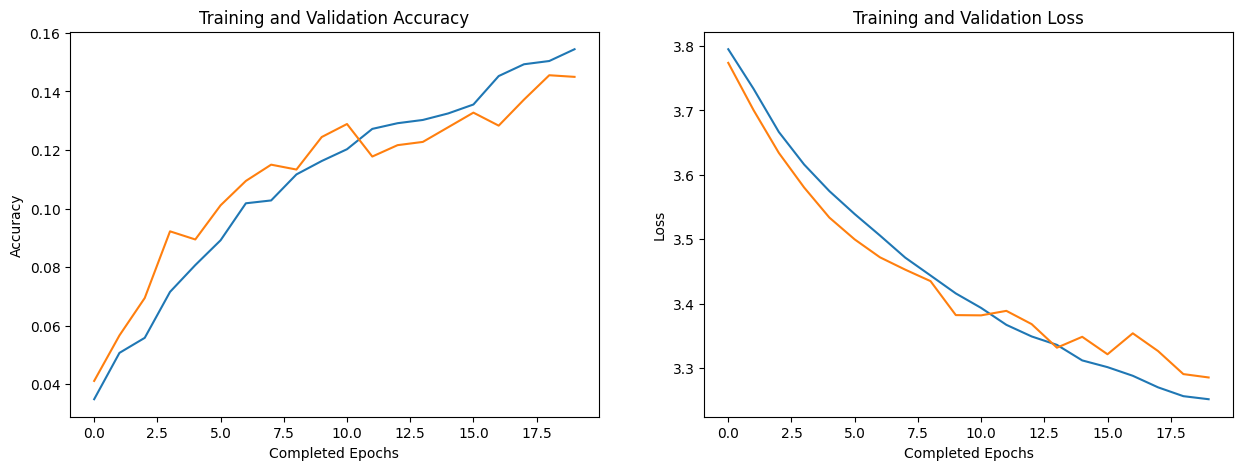

In [21]:
vis_logs(history_3)

After training, we observe a gradual reduction in both training and validation loss. Additionally, the validation accuracy shows an upward trend, getting closer to the training accuracy, indicating that the model is learning the patterns in the data while managing to reduce overfitting. The addition of **Dropout rate** of **10%** is helping in improving generalization of the model during the validation process.

## 5. Model Regularization: L2 Regularization

To further improve the generalization of the model and reduce the risk of overfitting, we will be implementing **L2 regularization** across all convolutional layers. We apply an **L2 penalty** of **0.01** to each convolutional layer using the **kernel_regularizer** parameter. This adjustment aims to strike a balance between model flexibility and stability during training.

In [22]:
num_classes = len(class_names)
l2 = 0.01

model_4 = Sequential([
    layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    data_augmentation, 
    layers.Rescaling(1./255),

    # First layer with 32 filters
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2)),
    layers.MaxPooling2D(),
    
    # Second layer with 64 filters
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2)),
    layers.MaxPooling2D(),

    # Third layer with 128 filters
    layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2)),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(num_classes, activation='softmax')
])

model_4.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       5,308,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 45)                  │           5,805 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,407,597 (20.63 MB)

 Trainable params: 5,407,597 (20.63 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_4.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
    )
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3, 
    min_lr=1e-6
)


history_4 = model_4.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=20,
  callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.0332 - loss: 4.8903 - val_accuracy: 0.0456 - val_loss: 4.3040 - learning_rate: 1.0000e-04
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.0483 - loss: 4.2174 - val_accuracy: 0.0644 - val_loss: 3.9469 - learning_rate: 1.0000e-04
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.0688 - loss: 3.9184 - val_accuracy: 0.0900 - val_loss: 3.7665 - learning_rate: 1.0000e-04
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.0852 - loss: 3.7770 - val_accuracy: 0.1033 - val_loss: 3.6603 - learning_rate: 1.0000e-04
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.1015 - loss: 3.6669 - val_accuracy: 0.1194 - val_loss: 3.5448 - learning_rate: 1.0000e-04
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.1110 - loss: 3.5962 - val_accuracy: 0.1356 - val_loss: 3.4749 - learning_rate: 1.0000e-04
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - acc

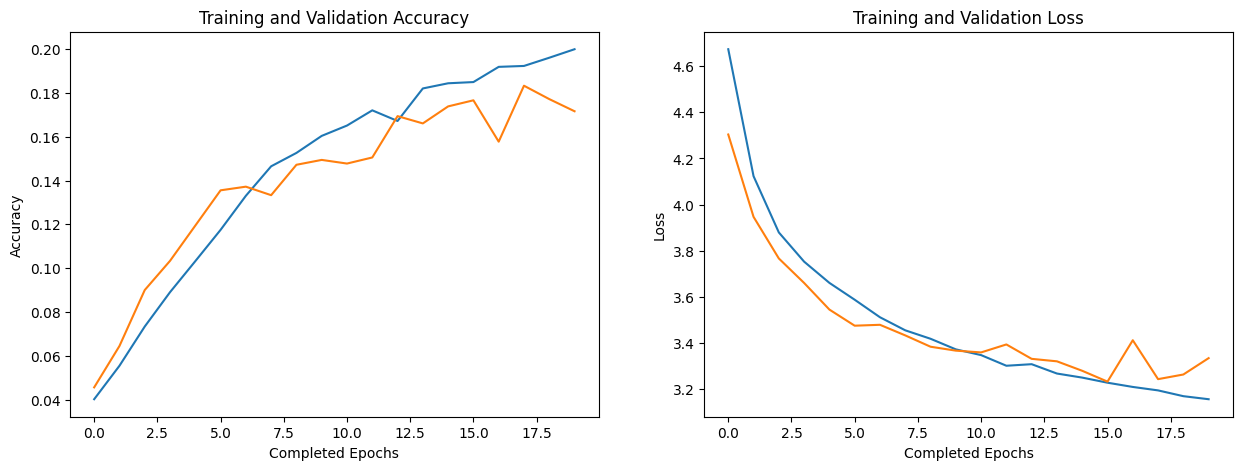

In [24]:
vis_logs(history_4)

After training, both validation accuracy and loss showed consistent improvement, with the model achieving a final validation accuracy of **17.17%** and validation loss of **3.3342**. L2 regularization effectively addressed overfitting by penalizing large weight values, leading to a more generalized model. The steady decline in validation loss indicates that the model continues to learn meaningful features without overfitting.

## 6. Conclusion

We are able to develop a Convolutional Neural Network model that is trained on the [Mammals Image Classification Dataset (45 Animals)](https://www.kaggle.com/datasets/asaniczka/mammals-image-classification-dataset-45-animals) with **45 classes**. As we build the baseline model with standard configuration of three convolutional layers, we have observed an overfitting issue, with the training accuracy reaching as high as **98%** while validation accuracy remained around **~20%**. To address the issue and improve the performance, we implemented **data augmentation**, **dropout**, and **L2 regularization** which helped improve generalization and stabilize the model's performance. 

Given the dataset size of only **200 images per class**, further increasing the number of epochs did not yield significant improvements in performance. The model achieved stability, indicating that the current dataset size might limit further accuracy gains.